# Supplying Oil Well Sites
This notebook demonstrates the processing of data collected by IoT sensors at multiple oil wells, for the purpose of prioritizing resupply of each well site.  Various chemicals are consumed at each well site at different rates and need to be replenished when running low.  In order to minimize resupply travel and costs, a prioritization algorithm is developed to yield the sites and routing of resupply trucks.

Set `local` to `True` if data are in the same folder are this notebook.

In [1]:
local = True

In [2]:
import pandas as pd
import numpy as np
import datetime

from  more_itertools import unique_everseen

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Discovery

Let's take a look at the data and get a handle on what we're looking at.

In [3]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

if(local):
    raw_data = pd.read_csv('onica3.csv')    
else:
    role = get_execution_role()
    bucket='sagemaker-iotanium-testing'
    data_key = 'onica3.csv'
    data_location = 's3://{}/{}'.format(bucket, data_key)
    raw_data = pd.read_csv(data_location)

Look at the first few rows of data

In [4]:
raw_data.head()

,site,asset,point,latestObservationTimestamp,latestObservation,rollupStartTimestampMs,rollupEndTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue
0,2540109280,2540109284,LATITUDE,1.509070e+12,40.210997,NaN,NaN,NaN,NaN,NaN,NaN
1,2540109280,2540109284,TANK_VOLUME,1.509070e+12,330,NaN,NaN,NaN,NaN,NaN,NaN
2,2540109280,2540109284,CHEMICAL_NAME,1.525990e+12,MX 2-4621,NaN,NaN,NaN,NaN,NaN,NaN
3,2540109280,2540109284,PRODUCT_VOLUME,NaN,NaN,1.529020e+12,1.529110e+12,83789.68918,289.765304,292.905543,290.076368
4,2540109280,2540109284,PRODUCT_VOLUME,NaN,NaN,1.529110e+12,1.529190e+12,83479.08299,288.751955,291.850937,289.273508


Different rows appear to contain different information and populate different columns.  We're going to have to clean this up before we can do much with it.  Let's check how many different kinds of rows there are:

In [5]:
list(unique_everseen(raw_data['point']))

['LATITUDE',
 'TANK_VOLUME',
 'CHEMICAL_NAME',
 'PRODUCT_VOLUME',
 'EST_DAYS_TO_EMPTY',
 'AVERAGE_CHEMICAL_DAILY_USAGE',
 'PERCENT_FULL',
 'LONGITUDE']

How many sites and assets (chemical types):

In [6]:
len(list(unique_everseen(raw_data['site'])))

250

In [7]:
len(list(unique_everseen(raw_data['asset'])))

250

In [8]:
len(list(unique_everseen(zip(raw_data['site'],raw_data['asset']))))

250

## ETL (Extract, Transform and Load)
The times are in the file as Unix epoch time (here, milliseconds from 1970-01-01); we'll turn them into datetime objects for clarity.

In [9]:
raw_data['rollupStartTimestampMs'] = pd.to_datetime(raw_data['rollupStartTimestampMs'], unit='ms')
raw_data['rollupEndTimestampMs'] = pd.to_datetime(raw_data['rollupEndTimestampMs'], unit='ms')
raw_data['latestObservationTimestamp'] = pd.to_datetime(raw_data['latestObservationTimestamp'], unit='ms')

In [10]:
raw_data.head()

,site,asset,point,latestObservationTimestamp,latestObservation,rollupStartTimestampMs,rollupEndTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue
0,2540109280,2540109284,LATITUDE,2017-10-27 02:06:40,40.210997,NaT,NaT,NaN,NaN,NaN,NaN
1,2540109280,2540109284,TANK_VOLUME,2017-10-27 02:06:40,330,NaT,NaT,NaN,NaN,NaN,NaN
2,2540109280,2540109284,CHEMICAL_NAME,2018-05-10 22:06:40,MX 2-4621,NaT,NaT,NaN,NaN,NaN,NaN
3,2540109280,2540109284,PRODUCT_VOLUME,NaT,NaN,2018-06-14 23:46:40,2018-06-16 00:46:40,83789.68918,289.765304,292.905543,290.076368
4,2540109280,2540109284,PRODUCT_VOLUME,NaT,NaN,2018-06-16 00:46:40,2018-06-16 23:00:00,83479.08299,288.751955,291.850937,289.273508


Some of the data rows are attributes of the site or asset, such as the latitude/longitude or chemical name.  We need to separate the timeseries data from these attribute data, and drop the columns not used in the timeseries data.

In [11]:
df_ts = raw_data[(raw_data.point == 'PRODUCT_VOLUME') | (raw_data.point == 'EST_DAYS_TO_EMPTY')| 
                 (raw_data.point == 'AVERAGE_CHEMICAL_DAILY_USAGE') | (raw_data.point == 'PERCENT_FULL')]

# drop attribute-related columns
del df_ts['latestObservationTimestamp']
del df_ts['latestObservation']

In [12]:
df_ts.head()

,site,asset,point,rollupStartTimestampMs,rollupEndTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue
3,2540109280,2540109284,PRODUCT_VOLUME,2018-06-14 23:46:40,2018-06-16 00:46:40,83789.68918,289.765304,292.905543,290.076368
4,2540109280,2540109284,PRODUCT_VOLUME,2018-06-16 00:46:40,2018-06-16 23:00:00,83479.08299,288.751955,291.850937,289.273508
5,2540109280,2540109284,PRODUCT_VOLUME,2018-06-16 23:00:00,2018-06-18 00:00:00,83168.02322,287.284156,291.472750,288.222951
6,2540109280,2540109284,PRODUCT_VOLUME,2018-06-18 00:00:00,2018-06-19 01:00:00,82774.13694,286.285754,289.646092,286.382614
7,2540109280,2540109284,PRODUCT_VOLUME,2018-06-19 01:00:00,2018-06-19 23:13:20,82427.02648,283.402635,289.124492,285.339462


Now extract the static attribute data:

In [13]:
df_attributes = raw_data[(raw_data.point == 'LATITUDE') | (raw_data.point == 'LONGITUDE')| 
                         (raw_data.point == 'TANK_VOLUME') | (raw_data.point == 'CHEMICAL_NAME')]

#Drop timeseries-related columns
del df_attributes['rollupStartTimestampMs']
del df_attributes['rollupEndTimestampMs']
del df_attributes['numericSumValue']
del df_attributes['numericMinValue']
del df_attributes['numericMaxValue']
del df_attributes['numericLastValue']

In [14]:
df_attributes.head()

,site,asset,point,latestObservationTimestamp,latestObservation
0,2540109280,2540109284,LATITUDE,2017-10-27 02:06:40,40.210997
1,2540109280,2540109284,TANK_VOLUME,2017-10-27 02:06:40,330
2,2540109280,2540109284,CHEMICAL_NAME,2018-05-10 22:06:40,MX 2-4621
280,2540109280,2540109284,LONGITUDE,2017-10-27 02:06:40,-110.394017
370,2539597784,2539597788,LONGITUDE,2017-10-26 01:06:40,-110.103104


In [15]:
df_attributes.dtypes

site                                   int64
asset                                  int64
point                                 object
latestObservationTimestamp    datetime64[ns]
latestObservation                     object
dtype: object

Perform some pandas pivot table magic to rearrange the data frame, and ensure the data are the right data type.

In [16]:
df_attributes = pd.pivot_table(df_attributes, 
                               index=['site','asset'], 
                               values=['latestObservation'],
                               columns=['point'], 
                               aggfunc=lambda x: ' '.join(map(str, x)))
# get rid of multi-level index
df_attributes = df_attributes.xs('latestObservation', axis=1, drop_level=True)
df_attributes = df_attributes.reset_index()

# convert the data with numeric data to the right data type
numeric_cols = ['LATITUDE','LONGITUDE','TANK_VOLUME']
df_attributes[numeric_cols] = df_attributes[numeric_cols].apply(pd.to_numeric)

In [17]:
df_attributes.head()

point,site,asset,CHEMICAL_NAME,LATITUDE,LONGITUDE,TANK_VOLUME
0,2539575528,2539575532,MX 2-4621,40.386460,-110.103161,330
1,2539597784,2539597788,MX 6-1086,40.386459,-110.103104,330
2,2539744844,2539744848,B-8630,40.398602,-110.103326,330
3,2539767100,2539767104,MX 534-5,40.386557,-110.103326,330
4,2539789356,2539789360,MX 826-2,40.378977,-110.149287,300


Merge timeseries data frame and attribute data frame.  Note that it's an inner join, so we're dropping sites with no timeseries information.

In [18]:
df = df_ts.merge(df_attributes, how = 'inner', on = ['site','asset'])

In [19]:
df.head()

,site,asset,point,rollupStartTimestampMs,rollupEndTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue,CHEMICAL_NAME,LATITUDE,LONGITUDE,TANK_VOLUME
0,2540109280,2540109284,PRODUCT_VOLUME,2018-06-14 23:46:40,2018-06-16 00:46:40,83789.68918,289.765304,292.905543,290.076368,MX 2-4621,40.210997,-110.394017,330
1,2540109280,2540109284,PRODUCT_VOLUME,2018-06-16 00:46:40,2018-06-16 23:00:00,83479.08299,288.751955,291.850937,289.273508,MX 2-4621,40.210997,-110.394017,330
2,2540109280,2540109284,PRODUCT_VOLUME,2018-06-16 23:00:00,2018-06-18 00:00:00,83168.02322,287.284156,291.472750,288.222951,MX 2-4621,40.210997,-110.394017,330
3,2540109280,2540109284,PRODUCT_VOLUME,2018-06-18 00:00:00,2018-06-19 01:00:00,82774.13694,286.285754,289.646092,286.382614,MX 2-4621,40.210997,-110.394017,330
4,2540109280,2540109284,PRODUCT_VOLUME,2018-06-19 01:00:00,2018-06-19 23:13:20,82427.02648,283.402635,289.124492,285.339462,MX 2-4621,40.210997,-110.394017,330


## EDA (Exploratory Data Analysis)

The primary value appears to be the `PRODUCT_VOLUME`, and the others are derived from that.  Let's look at a few sites timeseries data.

In [20]:
def plot_sites(sites, df, ycol='numericLastValue'):
    for site in sites:
        df_site = df[df['site']==site]
        for cname, group in df_site.groupby('CHEMICAL_NAME'):
            ax = group.plot(x='rollupEndTimestampMs', y=ycol, title=str(site), marker='+', label=cname)
            ax.set_xlabel('Time')
            ax.set_ylabel('Volume')
            #print(site)

In [21]:
site_list = list(unique_everseen(df['site']))

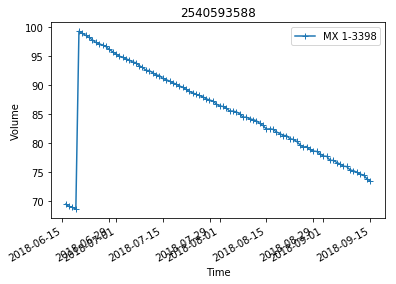

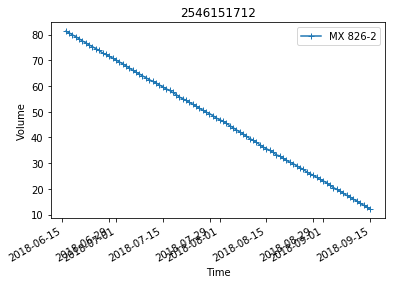

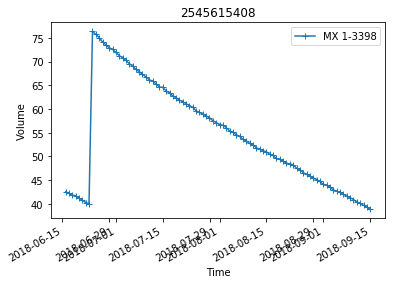

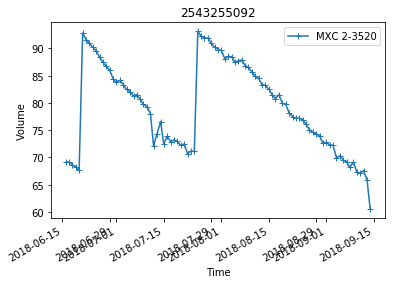

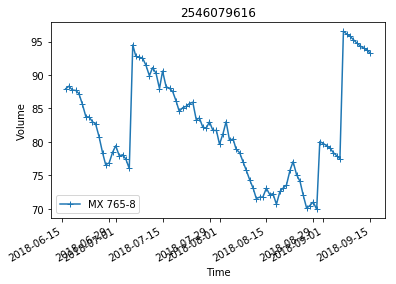

In [22]:
num_sample = 5
variable = 'PERCENT_FULL' #'PRODUCT_VOLUME'

df_variable = df[df['point']==variable].copy()

plot_sites(np.random.choice(site_list, num_sample), df_variable)

Chemicals at most sites follow a logical pattern of steady depletion with occasional fill events rapidly increasing chemical volume levels.  Here are a few with a "typical" pattern:

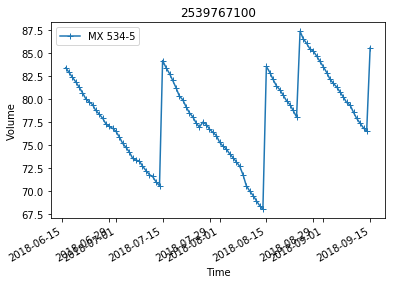

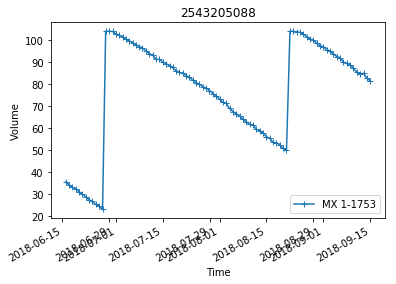

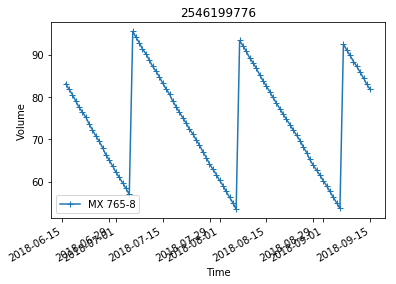

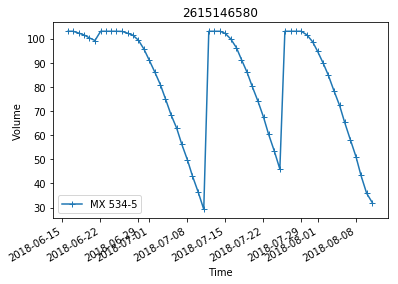

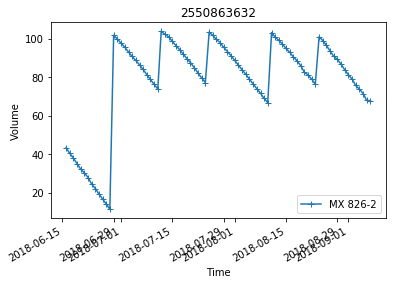

In [23]:
normal_sites = [2539767100, 2543205088, 2546199776, 2615146580, 2550863632]
plot_sites(normal_sites, df_variable)

However, there are some timeseries which don't make sense, like the reported volume dropping to zero, or a single value in the timeseries.  These are likely sensor failures of some kind.  Other sites show slow increases in volume, which seems strange but could be from thermal expansion of the chemicals in the tank.

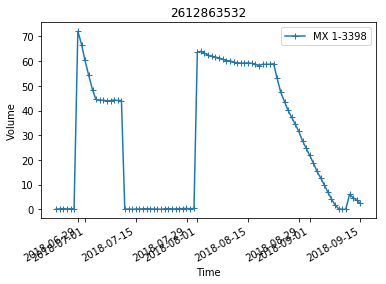

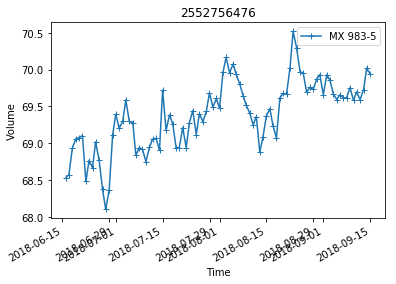

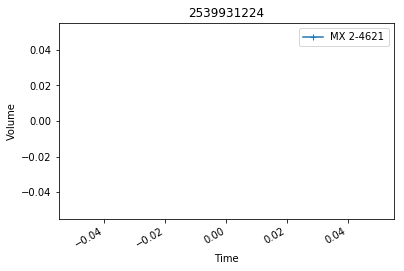

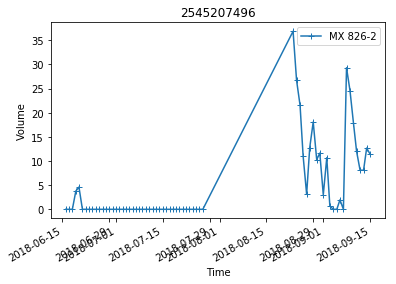

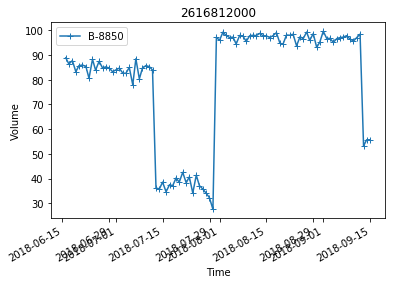

In [24]:
unusual_sites = [2612863532, 2552756476, 2539931224, 2545207496, 2616812000] #, 2552369860, 2553594584]
plot_sites(unusual_sites, df_variable)

# Empty Tank Prediction 

Normalize time stamp as 'date' to capture all movement within one day and allow for grouping/sorting if needed

In [25]:
df_variable['date'] = df_variable['rollupEndTimestampMs'].dt.normalize()

In [26]:
df_variable.sort_values(['site','asset','rollupEndTimestampMs'], inplace=True)

FIXME: this doesn't account for time deltas

In [27]:
(df_variable['rollupEndTimestampMs'] - df_variable['rollupEndTimestampMs'].shift()).apply(lambda x: x.total_seconds())

5276         NaN
5277     80000.0
5278     90000.0
5279     90000.0
5280     80000.0
5281     90000.0
5282     90000.0
5283     80000.0
5284     90000.0
5285     80000.0
5286     90000.0
5287     90000.0
5288     80000.0
5289     90000.0
5290     90000.0
5291     80000.0
5292     90000.0
5293     90000.0
5294     80000.0
5295     90000.0
5296     90000.0
5297     80000.0
5298     90000.0
5299     80000.0
5300     90000.0
5301     90000.0
5302     80000.0
5303     90000.0
5304     90000.0
5305     80000.0
          ...   
54576    80000.0
54577    90000.0
54578    90000.0
54579    80000.0
54580    90000.0
54581    90000.0
54582    80000.0
54583    90000.0
54584    90000.0
54585    80000.0
54586    90000.0
54587    80000.0
54588    90000.0
54589    90000.0
54590    80000.0
54591    90000.0
54592    90000.0
54593    80000.0
54594    90000.0
54595    90000.0
54596    80000.0
54597    90000.0
54598    80000.0
54599    90000.0
54600    90000.0
54601    80000.0
54602    90000.0
54603    90000

In [28]:
#Solve for daily percent full delta for any give site and asset

df_variable['percent_full_delta'] = np.where(df_variable['site'] == df_variable['site'].shift(), df_variable['numericLastValue'] - df_variable['numericLastValue'].shift() , np.nan)

In [29]:
def plot_multi(sites, df, ycol=['numericLastValue','percent_full_delta']):
    for site in sites:
        df_site = df[df['site']==site]
        for cname, group in df_site.groupby('CHEMICAL_NAME'):
            ax = group.plot(x='rollupEndTimestampMs', y=ycol, title=str(site), marker='+', label=[cname,'delta'])
            ax.set_xlabel('Time')
            ax.set_ylabel('Volume')

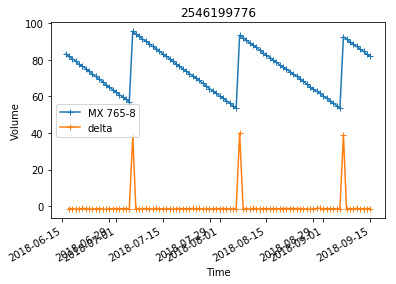

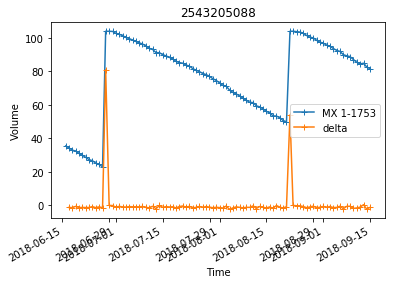

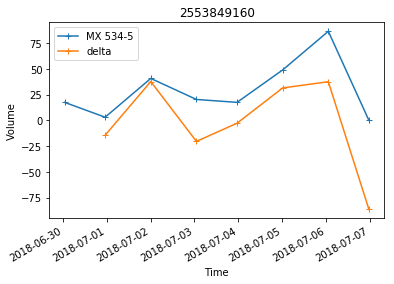

In [30]:
plot_multi([2546199776,2543205088,2553849160], df_variable) #, ycol='percent_full_delta')

In [31]:
threshold = 10
df_variable['fill_event'] = df_variable['percent_full_delta'] > threshold

In [32]:
df_mean_rate_of_depletion = df_variable[df_variable['fill_event']==False].groupby(['site','asset'], as_index=False).agg({"percent_full_delta":"mean"})
df_mean_rate_of_depletion.rename(columns={'percent_full_delta':'mean_rate_of_depletion'}, inplace=True)

In [33]:
df_mean_rate_of_depletion.head()

,site,asset,mean_rate_of_depletion
0,2539575528,2539575532,-1.528153
1,2539597784,2539597788,-2.461289
2,2539744844,2539744848,-0.806234
3,2539767100,2539767104,-0.303406
4,2539789356,2539789360,-0.829760


***Apply a rate of depletion to the current chemical levels to predict time to empty.***

In [34]:
#Pull latest percent full levels by site and asset

df_fill_prediction = df_variable.groupby(['site','asset'], as_index=False).agg({"rollupEndTimestampMs":"max"})

In [35]:
#Ties with depletion rate count, great!

df_fill_prediction.shape

(248, 3)

In [36]:
#Merge lateset time stamp to be predicted on with rates of depletion

df_fill_prediction = pd.merge(df_fill_prediction, df_mean_rate_of_depletion, on=['site','asset'])

In [37]:
df_fill_prediction.head()

,site,asset,rollupEndTimestampMs,mean_rate_of_depletion
0,2539575528,2539575532,2018-09-15 00:06:40,-1.528153
1,2539597784,2539597788,2018-09-11 23:53:20,-2.461289
2,2539744844,2539744848,2018-09-15 00:06:40,-0.806234
3,2539767100,2539767104,2018-09-15 00:06:40,-0.303406
4,2539789356,2539789360,2018-09-15 00:06:40,-0.829760


In [38]:
#Add other available fields at the latest timestamp for each site,asset

df_fill_prediction = pd.merge(df_fill_prediction, df_variable, on=['site','asset','rollupEndTimestampMs'])

In [39]:
#Data frame clean up

# df_fill_prediction.drop('point', axis=1, inplace=True)
# df_fill_prediction.drop('numericSumValue', axis=1, inplace=True) 
# df_fill_prediction.drop('numericMinValue', axis=1, inplace=True)
# df_fill_prediction.drop('numericMaxValue', axis=1, inplace=True)
# df_fill_prediction.drop('rollupStartTimestampMs', axis=1, inplace=True)
# df_fill_prediction.drop('fill_event', axis=1, inplace=True)
# df_fill_prediction.drop('percent_full_delta', axis=1, inplace=True)

In [40]:
df_fill_prediction.head()

,site,asset,rollupEndTimestampMs,mean_rate_of_depletion,point,rollupStartTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue,CHEMICAL_NAME,LATITUDE,LONGITUDE,TANK_VOLUME,date,percent_full_delta,fill_event
0,2539575528,2539575532,2018-09-15 00:06:40,-1.528153,PERCENT_FULL,2018-09-13 23:06:40,14729.466330,50.284974,52.018702,50.457370,MX 2-4621,40.386460,-110.103161,330,2018-09-15,-1.675509,False
1,2539597784,2539597788,2018-09-11 23:53:20,-2.461289,PERCENT_FULL,2018-09-10 22:53:20,6964.000305,80.778280,81.176224,81.132858,MX 6-1086,40.386459,-110.103104,330,2018-09-11,0.293356,False
2,2539744844,2539744848,2018-09-15 00:06:40,-0.806234,PERCENT_FULL,2018-09-13 23:06:40,19065.882760,65.123145,67.218184,65.135163,B-8630,40.398602,-110.103326,330,2018-09-15,-1.922625,False
3,2539767100,2539767104,2018-09-15 00:06:40,-0.303406,PERCENT_FULL,2018-09-13 23:06:40,22685.968420,76.032496,85.635167,85.597304,MX 534-5,40.386557,-110.103326,330,2018-09-15,9.109349,False
4,2539789356,2539789360,2018-09-15 00:06:40,-0.829760,PERCENT_FULL,2018-09-13 23:06:40,21114.921680,72.533338,73.987952,72.749825,MX 826-2,40.378977,-110.149287,300,2018-09-15,-0.874535,False


In [41]:
#Caclulate predicted days to empty

df_fill_prediction['days_to_empty'] = df_fill_prediction['numericLastValue'] / -(df_fill_prediction['mean_rate_of_depletion'])

In [42]:
df_fill_prediction.shape

(248, 18)

In [43]:
df_fill_prediction

,site,asset,rollupEndTimestampMs,mean_rate_of_depletion,point,rollupStartTimestampMs,numericSumValue,numericMinValue,numericMaxValue,numericLastValue,CHEMICAL_NAME,LATITUDE,LONGITUDE,TANK_VOLUME,date,percent_full_delta,fill_event,days_to_empty
0,2539575528,2539575532,2018-09-15 00:06:40,-1.528153,PERCENT_FULL,2018-09-13 23:06:40,14729.466330,50.284974,52.018702,50.457370,MX 2-4621,40.386460,-110.103161,330,2018-09-15,-1.675509,False,33.018543
1,2539597784,2539597788,2018-09-11 23:53:20,-2.461289,PERCENT_FULL,2018-09-10 22:53:20,6964.000305,80.778280,81.176224,81.132858,MX 6-1086,40.386459,-110.103104,330,2018-09-11,0.293356,False,32.963570
2,2539744844,2539744848,2018-09-15 00:06:40,-0.806234,PERCENT_FULL,2018-09-13 23:06:40,19065.882760,65.123145,67.218184,65.135163,B-8630,40.398602,-110.103326,330,2018-09-15,-1.922625,False,80.789430
3,2539767100,2539767104,2018-09-15 00:06:40,-0.303406,PERCENT_FULL,2018-09-13 23:06:40,22685.968420,76.032496,85.635167,85.597304,MX 534-5,40.386557,-110.103326,330,2018-09-15,9.109349,False,282.121343
4,2539789356,2539789360,2018-09-15 00:06:40,-0.829760,PERCENT_FULL,2018-09-13 23:06:40,21114.921680,72.533338,73.987952,72.749825,MX 826-2,40.378977,-110.149287,300,2018-09-15,-0.874535,False,87.675735
5,2539811612,2539811616,2018-09-15 00:06:40,-1.183414,PERCENT_FULL,2018-09-13 23:06:40,25991.509550,88.471716,91.511954,88.888874,MX 6-1086,40.378973,-110.149186,300,2018-09-15,-1.827746,False,75.112223
6,2539931224,2539931228,NaT,NaN,PERCENT_FULL,NaT,NaN,NaN,NaN,NaN,MX 2-4621,40.195578,-110.390363,130,NaT,NaN,False,NaN
7,2539953488,2539953492,2018-09-15 00:06:40,-1.547090,PERCENT_FULL,2018-09-13 23:06:40,21448.169340,73.342465,75.438015,73.653762,MX 765-8,40.240036,-110.393172,200,2018-09-15,-1.654961,False,47.607937
8,2539975744,2539975748,2018-09-15 00:06:40,-2.775709,PERCENT_FULL,2018-09-13 23:06:40,18334.747930,61.835478,65.840762,61.882079,MX 8-1024,40.208062,-110.354601,220,2018-09-15,-3.471620,False,22.294153
9,2539998000,2539998004,2018-08-17 23:53:20,-1.801088,PERCENT_FULL,2018-08-16 22:53:20,9506.987684,73.915601,74.478022,74.032524,MX 765-8,40.210955,-110.393994,220,2018-08-17,-0.306477,False,41.104333


***Forecast the date at which the tank will reach empty.***

In [44]:
df_fill_prediction = df_fill_prediction.replace([np.inf, -np.inf], np.nan).dropna(subset=["days_to_empty"], how="any")

For this exercise, drop the pathological rows.  In production, these would be flagged for inspection.

In [45]:
bad_idx = df_fill_prediction[(df_fill_prediction['mean_rate_of_depletion']>=0) | (df_fill_prediction['mean_rate_of_depletion']<-10)].index
df_fill_prediction.drop(bad_idx, inplace=True)

In [46]:
df_fill_prediction.shape

(226, 18)

In [47]:
np.sort(df_fill_prediction['mean_rate_of_depletion'])

array([-8.39181055e+00, -7.52922413e+00, -5.99091128e+00, -5.48648210e+00,
       -5.20494578e+00, -4.14584635e+00, -4.01882208e+00, -3.95814770e+00,
       -3.94285692e+00, -3.73829049e+00, -3.56506729e+00, -3.55728470e+00,
       -3.55257870e+00, -3.12569825e+00, -3.05042627e+00, -2.91449034e+00,
       -2.89201050e+00, -2.82289330e+00, -2.77570894e+00, -2.74074262e+00,
       -2.70023934e+00, -2.59091224e+00, -2.53836837e+00, -2.47566157e+00,
       -2.46128855e+00, -2.41415981e+00, -2.36037864e+00, -2.35403015e+00,
       -2.33806705e+00, -2.33065655e+00, -2.26461907e+00, -2.26330468e+00,
       -2.25788945e+00, -2.14650435e+00, -2.14519560e+00, -2.13667100e+00,
       -2.07174190e+00, -2.01612544e+00, -1.97836580e+00, -1.93759771e+00,
       -1.92812883e+00, -1.90550993e+00, -1.88363719e+00, -1.87459147e+00,
       -1.84241766e+00, -1.81488455e+00, -1.80108808e+00, -1.77256106e+00,
       -1.74217019e+00, -1.62022415e+00, -1.60619205e+00, -1.60505356e+00,
       -1.59983465e+00, -

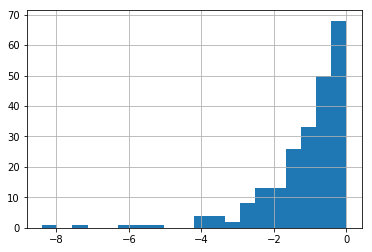

In [48]:
df_fill_prediction['mean_rate_of_depletion'].hist(bins=20)

(0, 100)

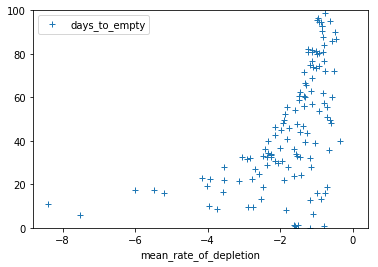

In [49]:
a=df_fill_prediction.plot(x='mean_rate_of_depletion', y='days_to_empty', linewidth=0, marker='+')
a.set_ylim(0,100)

***Filter for working sensors and prioritize site and chemical fill requirements by time to empty.***

# Clustering (K-Means)

***K-means on location and n = 5 clusters:***

In [50]:
R = 6371.0 #-- mean radius of curvatureof Earth (km)

In [51]:
lat0 = np.median(df_fill_prediction['LATITUDE'])
lon0 = np.median(df_fill_prediction['LONGITUDE'])
print(lat0)

40.230599999999995


In [52]:
df_fill_prediction['dN'] = np.radians(df_fill_prediction['LATITUDE'] - lat0) * R
df_fill_prediction['dE'] = np.radians(df_fill_prediction['LONGITUDE'] - lon0) * R * np.cos(np.radians(lat0))

In [53]:
from scipy import stats
from sklearn.cluster import KMeans

#Make a copy of DF
#must_fill = 30  #-- days
#df_tr = df_fill_prediction[df_fill_prediction['days_to_empty'] <= must_fill].copy()
df_tr = df_fill_prediction.copy()

#Standardize
#clmns = ['LONGITUDE', 'LATITUDE']
clmns = ['dE', 'dN']
df_tr_std = stats.zscore(df_tr[clmns])

In [54]:
#Cluster the data
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_tr_std)
labels = kmeans.labels_

#Glue back to original data
df_tr['cluster'] = labels

In [55]:
#Summarize clustering results

df_tr[['site','asset','cluster']].groupby(['cluster']).agg(['count'])

,site,asset
,count,count
cluster,,
0,70,70
1,16,16
2,20,20
3,115,115
4,5,5


Text(26.279322916666672, 0.5, 'Kilometers North')

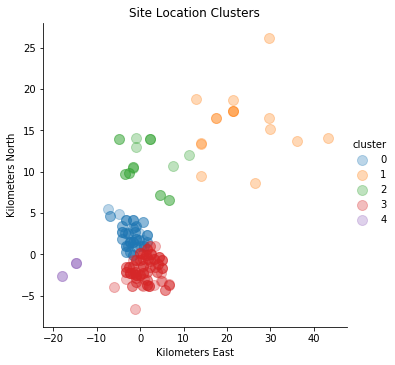

In [56]:
#Visualize clustering results; scatter plot of LONGITUDE and LATITUDE
sns.lmplot('dE','dN',
           data=df_tr, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100, "alpha": 0.3})
plt.title('Site Location Clusters')
plt.xlabel('Kilometers East')
plt.ylabel('Kilometers North')

***Identify minimum days to empty to prioritize fill schedule by cluster:***

In [57]:
#Group data by clusters and indentify the minimum days to empty for each cluster

df_cluster_min = df_tr.groupby(['cluster'], as_index=False).agg({"days_to_empty":"min"})

In [58]:
#Rename the days_to_empty comlumn to prepare merge with df_fill_prediciton

df_cluster_min = df_cluster_min.rename(columns={'days_to_empty':'min_days_to_empty'})

In [59]:
#Review

df_cluster_min

,cluster,min_days_to_empty
0,0,0.000000
1,1,1.274831
2,2,17.614610
3,3,1.038947
4,4,31.508653


# Algorithm for "Traveling Salesman Problem" (TSP)

In [60]:
# Calculate the euclidian distance in n-space of the route r traversing cities (sites) c, ending at the path start.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])

# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities (sites).
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city (site) except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities (sites) following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities (sites)
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.

# Source: https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy

In [61]:
df_cluster_min.sort_values('min_days_to_empty', inplace=True)
df_cluster_min

,cluster,min_days_to_empty
0,0,0.000000
3,3,1.038947
1,1,1.274831
2,2,17.614610
4,4,31.508653


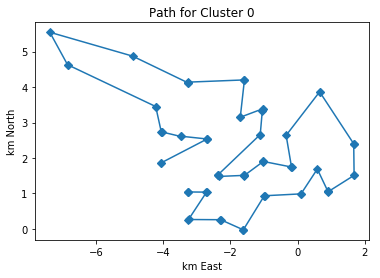

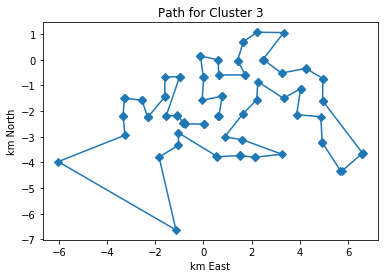

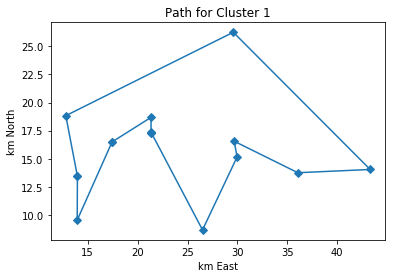

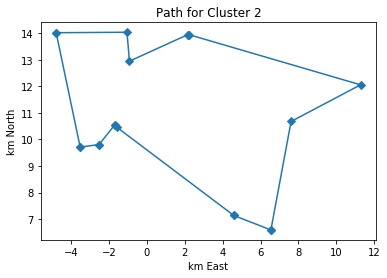

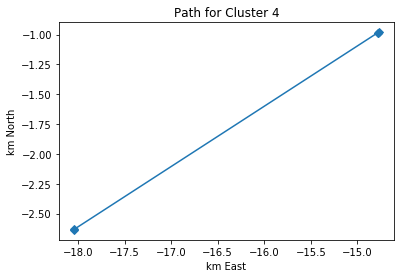

In [62]:
for c in df_cluster_min['cluster'].values:
    df_sites = df_tr[df_tr['cluster']==c]
    sites = df_sites[['dE','dN']].values
    
    # Find a good route with 2-opt ("route" gives the order in which to travel to each site by row number.)
    route = two_opt(sites,0.001)
    
    # Plot the recommended path
    ax = (df_sites.iloc[route]).plot(x='dE',y='dN', marker='D', title='Path for Cluster {}'.format(c))
    ax.set_xlabel('km East')
    ax.set_ylabel('km North')
    ax.get_legend().remove()